In [1]:
import subs.QUEST as qu
import sub.analysis as an
import numpy as np
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from sub.pytorchtools import EarlyStopping
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

In [2]:
df0 = pd.read_csv('27207.txt')
df1 = df0[['time', 'TFCkA', 'PlasmaCurrentkA', 'PF17kA', 'PF26kA']]
df1.columns = ['time', 'tfc', 'ip', 'pf17', 'pf26']
df1 = df1[df1['time']>=0.0]

In [3]:
cur_pf_pf26t36 = an.wave_resampling_freq(df1['time'],df1['pf26'],1000,kind='linear')
cur_ip_ip = an.wave_resampling_freq(df1['time'],df1['ip'],1000,kind='linear')

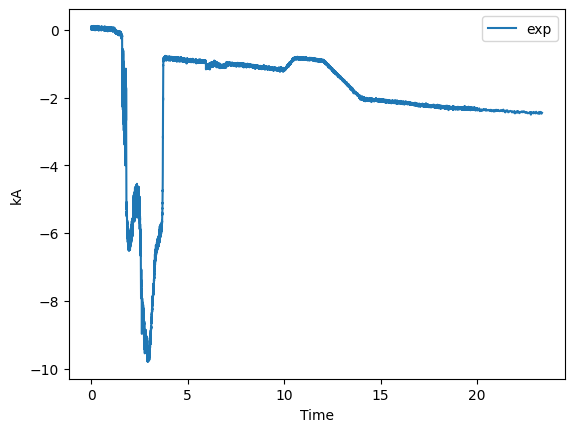

In [5]:
plt.figure()
plt.xlabel('Time')
plt.plot(df1["time"], df1['ip'], label = "exp")
plt.ylabel('kA')
plt.legend()
plt.show()

In [6]:
oz = 0.9e-3 
cz = 1.3e-3 #V/G

In [7]:
size = qu.readDecDaq01(27207, 1000)

In [8]:
time = size[0][1:23352]
bz_val_ozm400 = (size[1][4][1:23352]-np.mean(size[1][4][25000:26000]))/oz
bz_val_oz000 = (size[1][7][1:23352]-np.mean(size[1][7][25000:26000]))/oz
bz_val_ozp400 = (size[1][10][1:23352]-np.mean(size[1][10][25000:26000]))/oz

bz_val_czp800 = (size[1][16][1:23352]-np.mean(size[1][16][25000:26000]))/cz
bz_val_czp400 = (size[1][17][1:23352]-np.mean(size[1][17][25000:26000]))/cz
bz_val_cz000 = (size[1][18][1:23352]-np.mean(size[1][18][25000:26000]))/cz
bz_val_czm400 = -(size[1][19][1:23352]-np.mean(size[1][19][25000:26000]))/cz
bz_val_czm800 = -(size[1][20][1:23352]-np.mean(size[1][20][25000:26000]))/cz

In [9]:
col_in = ['cur_pf_pf26t36','bz_val_ozm400','bz_val_oz000','bz_val_ozp400','bz_val_czp800','bz_val_czp400','bz_val_cz000','bz_val_czm400','bz_val_czm800']
col_out = ['pts_z_rmin','pts_r_zmax','pts_z_zmax','pts_r_rmax','pts_z_rmax','pts_r_zmin','pts_z_zmin', 'r_ax', 'z_ax', 'ip']

In [10]:
X = pd.DataFrame(data = [cur_pf_pf26t36[1],bz_val_ozm400,bz_val_oz000,bz_val_ozp400,bz_val_czp800,bz_val_czp400,bz_val_cz000,bz_val_czm400,bz_val_czm800],index = col_in)

In [44]:
X.transpose()

cur_pf_pf26t36  bz_val_ozm400  bz_val_oz000  bz_val_ozp400  \
0            0.008818    -186.062482   -457.037360      95.806996   
1            0.011920    -177.392482   -460.600693      88.872551   
2            0.013866    -170.536927   -460.185138      87.823662   
3            0.013253    -181.442482   -458.849582      94.211440   
4            0.012499    -176.981371   -461.038471      84.490329   
...               ...            ...           ...            ...   
23346        0.008318       0.681962     -3.146249      -0.039671   
23347        0.008133      -0.359149     -0.556249      -6.126338   
23348        0.007947      -3.423593      0.350418      -0.007449   
23349        0.007761       0.030851     -0.558471      -1.738560   
23350        0.007575       0.274184      1.494862      -2.571893   

       bz_val_czp800  bz_val_czp400  bz_val_cz000  bz_val_czm400  \
0           2.523218       1.972312     -2.073092       1.071534   
1           2.518602       1.754620     -2.034631       1.160765   
2           2.548602       1.804620     -2.250785       1.178457   
3           2.773987       1.697697     -1.696169       0.916918   
4           2.620141       1.712312     -2.002323       1.041534   
...              ...            ...           ...            ...   
23346       0.045525      -0.278457      0.038446       0.095380   
23347       0.068602      -0.381534      0.256908      -0.313851   
23348       0.008602      -0.234611      0.043831       0.142303   
23349       0.194756      -0.068457     -0.070015      -0.110005   
23350       0.099372       0.016158     -0.187708      -0.139235   

       bz_val_czm800  
0           3.664522  
1           3.771445  
2           3.829138  
3           3.842215  
4           4.009138  
...              ...  
23346      -0.096247  
23347      -0.062401  
23348      -0.232401  
23349       0.062215  
23350      -0.279324  

[23351 rows x 9 columns]

In [11]:
X_stats = X.describe().transpose()

In [12]:
def norm(x):
  return (x - X_stats['mean']) / X_stats['std']
X_test_sc = norm(X)

In [15]:
X_test_sc = X_test_sc.assign(time = time)

In [17]:
X_test_sc.to_csv('normedinputs.txt')